#Rule Based NER (Named Entity Recognition) and Model-Based NER to Identify Government Entities in Court Documents

## Project Overview

This project is part of the Spring 2024 Knowledge Centric AI hackathon hosted by [KnowHax](https://www.knowhax.com/). The business problem being solved is identifying whether a government entity or person was involved in a court case soley utilizing a four column dataset with one column being that of'name' which was the primary column used to create the target labels of 'government' and 'person'. This custom made target was created in two ways: one being rules-based utilizing pattern recognition and the other being using a zero-shot large language model called GLiNER-medium-v2.1 found on [HuggingFace](https://huggingface.co/spaces/tomaarsen/gliner_medium-v2.1).

## Business Problem

The United States Criminal Justice System spends a total of approximately $264B per year. Limited national data exists about court systems more importantly who is being prosecuted and convicted and the outcomes of those convictions. [SCALES](https://docs.scales-okn.org/nlp/) seeks to connect data systems within the criminal justics system to evaluate the efficiency of the court systems and subsequent outcomes for research purposes. This project in particular wanted to focus on identifying when governments are involved in suits (for example policing and prison entities) versus persons to help support research efforts about government entity conditions and ciminal justice system resources.



In [2]:
# Uncomment to install necessary packages via google collab
!pip install wordcloud
!pip install gliner-spacy
!pip install pillow==9.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 58.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.6/202.6 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 20.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using ca

In [2]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score
nltk.download('punkt')
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler
from gliner_spacy.pipeline import GlinerSpacy

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Overview

The following was done by the project sponsor-SCALES
- Webscraped dockets from [PACER](https://pacer.uscourts.gov/) (Public Access to Court Electronic Records)
- Extracted named entities from each docket using a custom scraper
- These dockets covered several case lists that can be found [Here](https://docs.scales-okn.org/rdf/) covered national cases from 2002-2020.
- JSON and Turtle files can be downloaded [Here](http://scalesokndata.ci.northwestern.edu/#/home) (need to sign up for a FREE account)
- A CSV file was created with approximately 3.5 million rows from the above files
- Due to computational resources and time constraints the hacakathon team random sampled 100k rows from the CSV file which is found in the 'data' folder of this repo

### Column Info from Stakeholder Documentation

**Name**:  a party name that appears in one or more cases

**Extra Info:** some optional “extra info” about the party that may be listed on the docket

**Nature-of-suit subtype:** specifiying the type of case to which this party belongs (which
can also be diagnostic in certain situations)

**UCIDs:** case IDs containing parties matching the description given in this row (in
case you want to look at the underlying case files that contain a certain party)

As mentioned above the **name** and **extra_info** columns were predominately used for this NER classifier

### Exploratory Data Analysis

In [3]:
samp_df = pd.read_csv('/content/samp_df_scales_v1_100k.csv')
samp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   name                 99999 non-null   object
 1   extra_info           29192 non-null   object
 2   nature_suit_subtype  100000 non-null  object
 3   ucids                100000 non-null  object
dtypes: object(4)
memory usage: 3.1+ MB


In [11]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426']
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006']
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929']
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953']
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864']


We are missing one name, that row will need to be dropped below as it is the primary column we are using to identify the entity. The **extra_info** column is missing a large portion of data but we will keep it in and use when it is available, but need to make sure to account for nulls values showing up.

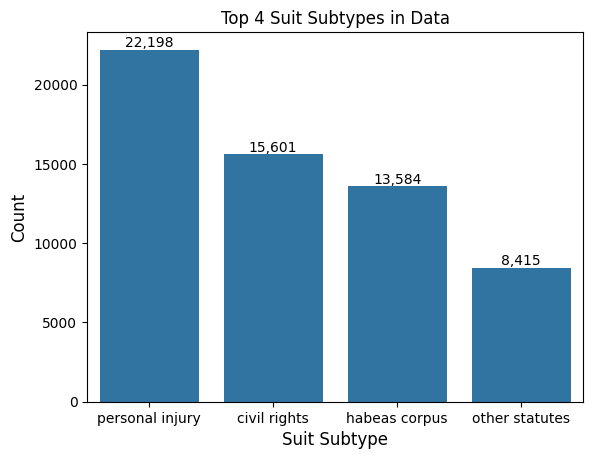

In [12]:
top_categories = samp_df['nature_suit_subtype'].value_counts().nlargest(4).index.tolist()
filtered_df = samp_df[samp_df['nature_suit_subtype'].isin(top_categories)]
ax = sns.countplot(x=filtered_df['nature_suit_subtype'], order=top_categories)
plt.title("Top 4 Suit Subtypes in Data")
plt.xlabel('Suit Subtype', fontsize=12)
plt.ylabel('Count', fontsize=12)
new_labels = [label.get_text().replace('_', ' ') for label in ax.get_xticklabels()]
ax.set_xticklabels(new_labels)
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:,.0f}'.format(bar.get_height()),
            horizontalalignment='center', verticalalignment='bottom', fontsize=10)

plt.show()

#alot of personal injury suits can be govt or personal though

In [13]:
### Just checking for duplicates across three features the ucids store the unique case info there are no dups
duplicates = samp_df[samp_df.duplicated(subset=['name', 'extra_info', 'ucids'], keep=False)]
duplicates.shape

(0, 4)

In [14]:
##Get tokens to see how long the names are and if any standout

def tokenize_column(df, column_name):
    # Define a tokenizer function
    def tokenizer(text):
        if pd.isna(text):
            return []
        tokens = word_tokenize(text)
        # Convert each token to lowercase
        tokens_lower = [token.lower() for token in tokens]
        return tokens_lower
    df[column_name + '_tokenized'] = df[column_name].apply(tokenizer)

    return df

In [15]:
samp_function_copy = samp_df.copy()

In [16]:
#lowercase/tokenize name using functions above
samp_df = tokenize_column(samp_df, 'name')

In [17]:
#lowercase/tokenize 'extra_info' column as well
samp_df = tokenize_column(samp_df, 'extra_info')

In [18]:
#sanity check
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized
0,Darren Bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[]
1,Officer Aaron Collier,CVPD,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd]
2,John Doe No. 2,"Correctional Sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca..."
3,Pearlie M Harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[]
4,DANIEL RANDALL,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[]


In [19]:
#Create a feature that is summing up all the tokens
samp_df['token_count'] = samp_df['name_tokenized'].apply(lambda x: len(x))

In [20]:
samp_df['token_count'].value_counts().sort_index()
#tokens from 0 to 46

token_count
0         1
1      4398
2     45140
3     26427
4      7800
5      7113
6      4860
7      1904
8       970
9       482
10      261
11      164
12      102
13       81
14       69
15       39
16       31
17       27
18       20
19       15
20       10
21       14
22        7
23       11
24        4
25        5
26        3
27        3
28        7
29        7
30        3
31        5
32        1
34        1
37        3
38        1
39        1
40        2
41        1
42        2
43        1
44        1
45        1
46        2
Name: count, dtype: int64

<Axes: xlabel='token_count'>

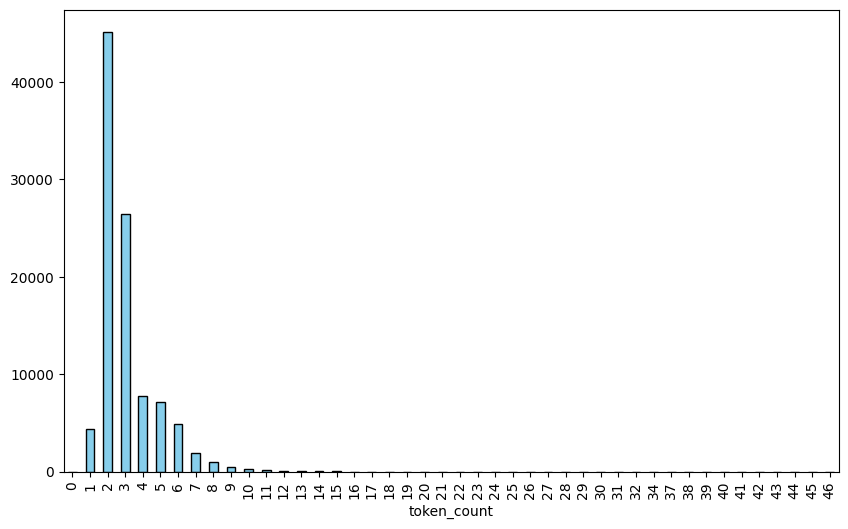

In [21]:
#Visualize the number of tokens across data -- 2 and 3 tokens comprise the 'name' field the most

plt.figure(figsize=(10, 6))
samp_df['token_count'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')

The majority of our **name** column values contain only 2 or 3 tokens, worth exploration into how we could create regex rules based on these tokens in order to identify entity. Can we use key words and phrases to 'classify' as person or government? Rows with larger tokens are explored below, keys words appear in there so our rules should work to capture these as well.

In [22]:
samp_df.describe()
#outlier Q3 + 1.5*IQR =4.5 ~ 5
#zone in on the tail starting at 20 tokens

,token_count
count,100000.000000
mean,3.077600
std,1.864155
min,0.000000
25%,2.000000
50%,3.000000
75%,3.000000
max,46.000000


In [23]:
big_tokens = samp_df.loc[samp_df['token_count']>=20]
big_tokens
#96 of them

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count
1293,"Unknown Stockholders, Officers, Successors, Tr...",NaN,real_property,['ned;;8:17-cv-00346'],"[unknown, stockholders, ,, officers, ,, succes...",[],23
2303,"IBEW LOCAL 102 WELFARE, PENSION ANNUITY AND JO...",NaN,labor,['njd;;2:17-cv-02689'],"[ibew, local, 102, welfare, ,, pension, annuit...",[],20
3587,"Deutsche Bank National Trust Company, as Trust...",NaN,contract,['ilnd;;1:06-cv-01733'],"[deutsche, bank, national, trust, company, ,, ...",[],31
4090,Fifteen Thousand Seven Hundred Sixty-One and N...,"Registered to Jay Sharon, and All Proceeds Tra...",forfeiture/penalty,['nyed;;1:16-cv-04914'],"[fifteen, thousand, seven, hundred, sixty-one,...","[registered, to, jay, sharon, ,, and, all, pro...",37
4694,"Harrington and Richardson Arms, Sportsman, Dou...",NaN,forfeiture/penalty,['ilcd;;4:17-cv-04087'],"[harrington, and, richardson, arms, ,, sportsm...",[],20
...,...,...,...,...,...,...,...
98309,"Electrolux Home Products, Inc. f/k/a White Con...",NaN,personal_injury,"['mad;;1:16-cv-11614', 'mad;;1:16-cv-11614', '...","[electrolux, home, products, ,, inc., f/k/a, w...",[],21
98579,"TEVA WOMEN'S HEALTH INC., INDIVIDUALLY, AND AS...",NaN,personal_injury,"['paed;;2:21-cv-00075', 'paed;;2:20-cv-05711',...","[teva, women, 's, health, inc., ,, individuall...",[],28
98666,THE LABORERS' DISTRICT COUNCIL OF THE METROPOL...,RYAN BOYER AS TRUSTEE AD LITEM,labor,"['paed;;2:13-cv-03552', 'paed;;2:11-cv-04440',...","[the, laborers, ', district, council, of, the,...","[ryan, boyer, as, trustee, ad, litem]",20
98897,"United Steel, Paper, and Forestry, Rubber, Man...","USW Local #7-507,",contract,['ilnd;;1:07-cv-05410'],"[united, steel, ,, paper, ,, and, forestry, ,,...","[usw, local, #, 7-507, ,]",21


According to information from the stakeholder "John/Jane Doe" is used in place of real names for select individuals in order to provide and maintain annomity and could be either government or person entity making it difficult to use the **name** column as an identifier. Exploring these rows shows that a good number of them contain **extra_info** which we will attempt to utilize as well.

In [24]:
#search for john does can be govt or person
result_johndoe = samp_df[samp_df['name_tokenized'].apply(lambda x: 'john' in x and 'doe' in x)]

In [25]:
result_johndoe.tail(50)

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count
90773,M.D. John Doe,#2 attending emergency room physician at Freep...,habeas_corpus,['ilnd;;3:06-cv-50144'],"[m.d, ., john, doe]","[#, 2, attending, emergency, room, physician, ...",4
91244,John Doe Lincoln County Sheriff,NaN,habeas_corpus,['wiwd;;3:17-cv-00309'],"[john, doe, lincoln, county, sheriff]",[],5
91329,John Doe,Correctional Officer at Jacksonville Correctio...,habeas_corpus,"['ilcd;;3:16-cv-03140', 'ilcd;;3:17-cv-03040']","[john, doe]","[correctional, officer, at, jacksonville, corr...",2
91360,John Doe #2,individual official capacity,habeas_corpus,['ilnd;;1:14-cv-08791'],"[john, doe, #, 2]","[individual, official, capacity]",4
91396,JOHN DOE SUBSCRIBER ASSIGNED IP ADDRESS 108.52...,NaN,property_rights,['paed;;2:20-cv-05130'],"[john, doe, subscriber, assigned, ip, address,...",[],7
91597,John Doe,Executive Director of Cook County Department o...,habeas_corpus,['ilnd;;1:15-cv-02507'],"[john, doe]","[executive, director, of, cook, county, depart...",2
91664,STATE POLICE OFFICER JOHN DOE,NOS. 1 AND 2,personal_injury,['paed;;2:04-cv-21202'],"[state, police, officer, john, doe]","[nos, ., 1, and, 2]",5
91746,John Doe Albaladejo-Santiago,(the Estate of Jose Albaladejo-Santiago),real_property,['prd;;3:16-cv-02612'],"[john, doe, albaladejo-santiago]","[(, the, estate, of, jose, albaladejo-santiago...",3
91815,John Doe No. 2,Inmate Trustee,civil_rights,['tned;;3:17-cv-00401'],"[john, doe, no, ., 2]","[inmate, trustee]",5
91915,John Doe,"Dentist, individual capacity",habeas_corpus,['ilnd;;1:15-cv-07943'],"[john, doe]","[dentist, ,, individual, capacity]",2


In [26]:
#580 John Does -- do they have 'extra_info' that may help?
result_johndoe.shape

(580, 7)

In [27]:
#Over 60% of John Does have extra_info so we can use this column to throw them into a group
result_johndoe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 580 entries, 2 to 99568
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   name                  580 non-null    object
 1   extra_info            364 non-null    object
 2   nature_suit_subtype   580 non-null    object
 3   ucids                 580 non-null    object
 4   name_tokenized        580 non-null    object
 5   extra_info_tokenized  580 non-null    object
 6   token_count           580 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 36.2+ KB


We have identified some key tokens of interest that could help in identify goverment entities, this list was continually updated as we explored varying samples and datapoints. Most of these tokens, which appear in the **name** column, denote a particular government position or title.

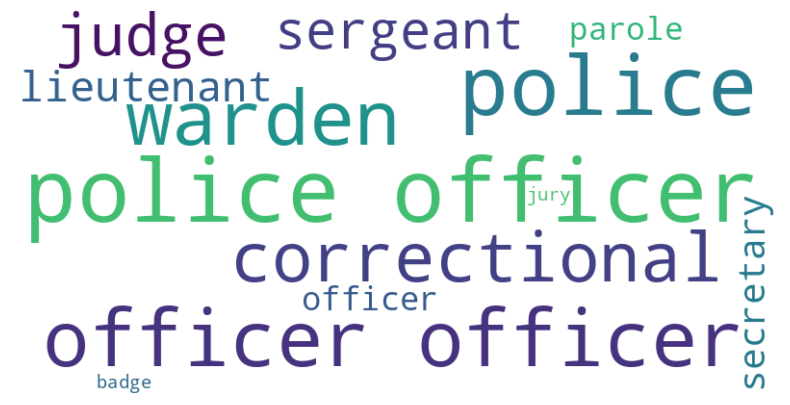

In [28]:
#WordCloud total dataframe
tokens_of_interest = ['officer', 'secretary', 'correctional', 'district attorney', 'd.a.', 'warden', 'police',
                      'judge', 'district attorney\'s', 'p.o.', 'jury', 'badge', 'sergeant', 'lieutenant', 'parole']

filtered_tokens = [word for sublist in samp_df['name_tokenized'] for word in sublist if word in tokens_of_interest]


text = ' '.join(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

For the "John Doe" values, looking into the **extra_info** column highlights that these tokens of interest often show up here, meaning we can use this information in our rule based approach.

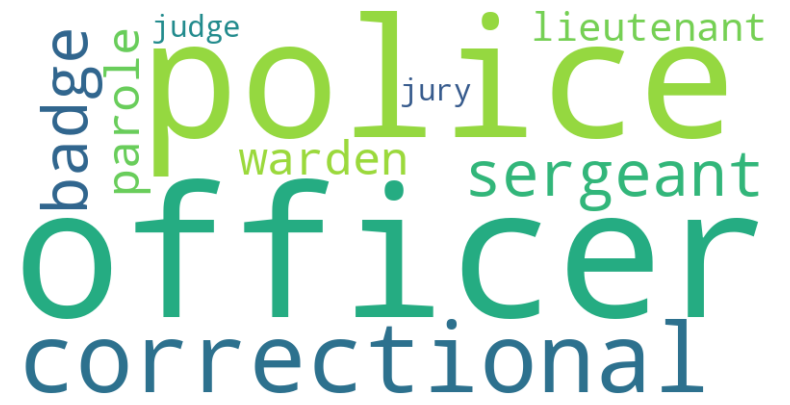

In [29]:
#Wordcloud for John Does for extra_info column

tokens_of_interest = ['officer', 'secretary', 'correctional', 'district attorney', 'd.a.', 'warden', 'police',
                      'judge', 'district attorney\'s', 'p.o.', 'jury', 'badge', 'sergeant', 'lieutenant', 'parole']

filtered_tokens = [word for sublist in result_johndoe['extra_info_tokenized'] for word in sublist if word in tokens_of_interest]


text = ' '.join(filtered_tokens)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#word cloud has some formal titles in the 'extra_info' columns for john does so may can classify those as govt
#want to err on overly classifying government per stakeholder request

Our goal is to create a binary target (person or government) using a decision rule based methodology, based primarily around regex checks within the name and extra_info columns, then classify each row as person (non-govt) vs government. This is stakeholder definition of government:

"We are interested in the parties (i.e. people or groups involved in litigation) listed on each
docket sheet. Specifically, we hope to develop a method for determining whether a given party
falls into a category we’re calling “government entities.” For our purposes, a government entity is
either a literal governing body (“United States,” “City of Chicago”), a subsidiary or affiliate of
a governing body (“U.S. Department of Education,” “Chicago Police Dept”), or a person
working for one of the above (“Secretary of Education Miguel Cardona,” “Officer Joe Smith”)"

**note it is better to overly classify it as government if there is a suspicion that it may be govt**

## Rule Based Methodology
1. Create Rules that matches patterns within the name and/or extra_info columns to classify 'government' versus 'person'
2. Some examples of rules are as follows:
   - Column(s) contain a 'formal government title' (i.e. Police, District Attornet, Lieutenant, etc.)
   - Column(s) contain 'city of' or 'department of' (rationale these are mostly state counties involved in the suit which is government)
   - Column(s) DO NOT contain 'llc' (these are mostly 'persons')
3. Build a target based on the rules (binary target of label 'government' or 'person')
4. From that target create a predictive rule-based model, Decision Tree, that uses binary features to predict that target
5. Limitations:  The target was created based on finite rules that may not encompass ALL PATTERNS

Potential rules to create to help identify entity. All rules should be 'True' if it applies to government entities. These rules were brainstormed via an iterative approach through trail and error. These rules are to be applied seqeuntially giving higher priority to the first rules checked in order to avoid overwriting labels already identified.


1. Contains u . s .
2. Contains 'department of'
3. Contains the word 'city of' (saw some examples with **indiv of estate** so added the word 'city' in front of this for narrower scope)
4. DOES NOT Contains 'LLC' (indiv business)
5. Formal Titles in NAME field ('Secretary, Officer, Judge, d.a.)
6. DOES NOT have 'word single letter than word' (most likely individuals)?
7. If it contains Dept (rule 2 won't capture this)
8. Two or Three tokens (most likely indivdual if other rules don't output govt)
9. If extra_info DOES NOT contain 'indiv'
10. extra_info contains formal titles
11. DOES NOT have llc (without the periods)
12. Contains inc. for incorporated businesses (individual?)




### Create new features based on regex pattern (exploration purposes)

In [4]:
#drop that one missing 'name' value found above
samp_df = samp_df.dropna(subset='name')

In [5]:
#make columns lowercase
samp_df['name'] = samp_df['name'].str.lower()
samp_df['extra_info'] = samp_df['extra_info'].str.lower()

In [32]:
#Matches rule 1 above -- contains u.s.

regex1 =  r'u\.s\.'
samp_df = samp_df.assign(let_period_let_regex=samp_df['name'].str.contains(regex1))

In [33]:
#Sanity Check
samp_df['let_period_let_regex'].value_counts()
samp_df[samp_df['let_period_let_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex
979,pentax u.s.a. inc.,NaN,other_statutes,['ilnd;;1:07-cv-06458'],"[pentax, u.s.a., inc, .]",[],4,True
1400,u.s. attorney,NaN,civil_rights,"['ohnd;;3:17-cv-00398', 'hid;;1:17-cv-00262', ...","[u.s., attorney]",[],2,True
1474,u.s. bank national association,as indentured trustee for sasco mortgage loan ...,real_property,['txsd;;3:17-cv-00215'],"[u.s., bank, national, association]","[as, indentured, trustee, for, sasco, mortgage...",4,True
1675,u.s. court of appeals of the third circuit,NaN,civil_rights,['paed;;2:16-cv-06153'],"[u.s., court, of, appeals, of, the, third, cir...",[],8,True
1701,u.s. attorney general .,NaN,habeas_corpus,['paed;;2:05-cv-02451'],"[u.s., attorney, general, .]",[],4,True
...,...,...,...,...,...,...,...,...
98096,u.s. ice field office director for the miami f...,"marc j. moore, field operation director",habeas_corpus,"['gasd;;5:17-cv-00160', 'flsd;;1:17-cv-24039']","[u.s., ice, field, office, director, for, the,...","[marc, j., moore, ,, field, operation, director]",10,True
98764,u.s. department of homeland security,(dhs),other_statutes,['gand;;1:17-cv-00353'],"[u.s., department, of, homeland, security]","[(, dhs, )]",5,True
99316,u.s. parole commissioner,et al.,habeas_corpus,['paed;;2:13-cv-03317'],"[u.s., parole, commissioner]","[et, al, .]",3,True
99658,white house u.s.a.,NaN,civil_rights,['vaed;;2:17-cv-00220'],"[white, house, u.s.a, .]",[],4,True


In [34]:
#Matches rule 2 above -- contains department of

regex2 = r'\bdepartment\s+of\b'
samp_df = samp_df.assign(dept_of_regex=samp_df['name'].str.contains(regex2))

In [35]:
samp_df['dept_of_regex'].value_counts()
samp_df[samp_df['dept_of_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex
232,wyoming department of corrections state penite...,in his official capacity\nalso known as\nethan...,habeas_corpus,['wyd;;2:17-cv-00153'],"[wyoming, department, of, corrections, state, ...","[in, his, official, capacity, also, known, as,...",8,False,True
491,somerville department of public works,NaN,civil_rights,['mad;;1:17-cv-12071'],"[somerville, department, of, public, works]",[],5,False,True
654,wyoming department of corrections state penite...,in his/her official capacity\nalso known as\ns...,habeas_corpus,['wyd;;1:16-cv-00244'],"[wyoming, department, of, corrections, state, ...","[in, his/her, official, capacity, also, known,...",8,False,True
990,sacramento department of justice,NaN,civil_rights,['caed;;2:16-cv-03029'],"[sacramento, department, of, justice]",[],4,False,True
1644,united states department of air force,NaN,civil_rights,['nmd;;1:17-cv-01272'],"[united, states, department, of, air, force]",[],6,False,True
...,...,...,...,...,...,...,...,...,...
97729,united states department of health and human s...,NaN,personal_injury,"['txsd;;3:20-cv-00058', 'nynd;;1:16-cv-01399',...","[united, states, department, of, health, and, ...",[],8,False,True
98247,department of homeland security,united states immigration and customs enforcement,civil_rights,['nvd;;3:17-cv-00257'],"[department, of, homeland, security]","[united, states, immigration, and, customs, en...",4,False,True
98726,south carolina department of motor vehicles,NaN,civil_rights,"['scd;;3:17-cv-00217', 'scd;;3:17-cv-02224', '...","[south, carolina, department, of, motor, vehic...",[],6,False,True
98764,u.s. department of homeland security,(dhs),other_statutes,['gand;;1:17-cv-00353'],"[u.s., department, of, homeland, security]","[(, dhs, )]",5,True,True


In [36]:
#Matches rule 3 above -- contains city of

regex3 = r'\bcity of\b'
samp_df = samp_df.assign(cityof_regex=samp_df['name'].str.contains(regex3))

In [37]:
#Sanity Check
samp_df[samp_df['cityof_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex
189,"montgomery, city of",NaN,civil_rights,"['mied;;5:17-cv-12920', 'nvd;;3:17-cv-00074', ...","[montgomery, ,, city, of]",[],4,False,False,True
380,city of chicago,as a corporation,civil_rights,['ilnd;;1:06-cv-03433'],"[city, of, chicago]","[as, a, corporation]",3,False,False,True
504,city of philadelphia police officer john doe 1,individually and as a police officer for the c...,habeas_corpus,['paed;;2:19-cv-04754'],"[city, of, philadelphia, police, officer, john...","[individually, and, as, a, police, officer, fo...",8,False,False,True
514,city of santa monica,a municipal corporation,other_statutes,['cacd;;2:16-cv-04481'],"[city, of, santa, monica]","[a, municipal, corporation]",4,False,False,True
679,"city of new albany, indiana",NaN,civil_rights,['insd;;4:17-cv-00185'],"[city, of, new, albany, ,, indiana]",[],6,False,False,True
...,...,...,...,...,...,...,...,...,...,...
99277,city of wilkes-barre,NaN,civil_rights,['pamd;;3:17-cv-00239'],"[city, of, wilkes-barre]",[],3,False,False,True
99584,"ashville, city of",NaN,civil_rights,['alnd;;4:21-cv-01502'],"[ashville, ,, city, of]",[],4,False,False,True
99627,city of espanola,a municipal corporation,personal_injury,['nmd;;1:17-cv-00648'],"[city, of, espanola]","[a, municipal, corporation]",3,False,False,True
99790,frisco city of,NaN,contract,['txed;;4:17-cv-00311'],"[frisco, city, of]",[],3,False,False,True


In [38]:
#Matches rule 4 above -- does NOT contain l.l.c
regex4 = r'^(?!.*l\.l\.c\.).*$'
samp_df = samp_df.assign(llc_regex=samp_df['name'].str.contains(regex4))

In [39]:
#Sanity Check
samp_df[samp_df['llc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...
99995,creighton e. miller,administrator of the estate of (deceased) jame...,personal_injury,['paed;;2:11-cv-34941'],"[creighton, e., miller]","[administrator, of, the, estate, of, (, deceas...",3,False,False,False,True
99996,sinohe antonio araujo meza,also known as\ncarrera,crim,['nysd;;1:16-cr-00680'],"[sinohe, antonio, araujo, meza]","[also, known, as, carrera]",4,False,False,False,True
99997,ruthie myers,NaN,civil_rights,['mowd;;5:16-cv-06121'],"[ruthie, myers]",[],2,False,False,False,True
99998,gerald f. morris,NaN,personal_injury,"['paed;;2:13-cv-06591', 'paed;;2:13-cv-06591',...","[gerald, f., morris]",[],3,False,False,False,True


In [40]:
#Matches rule 5 above -- matches a formal govt title in 'name' field
regex5 = r'(?:officer|secretary|correctional|district attorney|d.a.|warden|police|judge|district attorney\'s|p.o.|jury|badge|sergeant|lieutenant|parole)\s+\w+'
samp_df = samp_df.assign(formal_name_regex=samp_df['name'].str.contains(regex5))

In [41]:
#Sanity Check
samp_df[samp_df['formal_name_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True
11,real property located at 2255 elkhorn boulevar...,apn: 207-0202-046-0000,forfeiture/penalty,['caed;;2:16-cv-02394'],"[real, property, located, at, 2255, elkhorn, b...","[apn, :, 207-0202-046-0000]",12,False,False,False,True,True
61,officer robert otto,NaN,civil_rights,['paed;;2:17-cv-05189'],"[officer, robert, otto]",[],3,False,False,False,True,True
63,police officer david killingsworth,NaN,civil_rights,['paed;;2:13-cv-00256'],"[police, officer, david, killingsworth]",[],4,False,False,False,True,True
97,sergeant fnu valdez,correctional officer at estelle unit,habeas_corpus,['txwd;;5:20-cv-00769'],"[sergeant, fnu, valdez]","[correctional, officer, at, estelle, unit]",3,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
99610,"wyndham worldwide operations, inc.",NaN,labor,['gand;;1:17-cv-03680'],"[wyndham, worldwide, operations, ,, inc, .]",[],6,False,False,False,True,True
99750,sergeant smith,of division 1,habeas_corpus,['ilnd;;1:09-cv-00813'],"[sergeant, smith]","[of, division, 1]",2,False,False,False,True,True
99759,police officer david ortiz,NaN,habeas_corpus,['nysd;;7:17-cv-08886'],"[police, officer, david, ortiz]",[],4,False,False,False,True,True
99931,police officers john does 1-5,NaN,civil_rights,"['nyed;;1:16-cv-00127', 'nyed;;1:16-cv-02631',...","[police, officers, john, does, 1-5]",[],5,False,False,False,True,True


In [42]:
#Matches rule 6 above -- DOES NOT have word single letter than word

regex6 = r'^(?!\b\w+\s+[a-zA-Z]\s+\w+\b).*$'

samp_df = samp_df.assign(word_let_word_regex=samp_df['name'].str.contains(regex6))


In [43]:
samp_df[samp_df['word_let_word_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True
5,jennie jones-hurdlow,NaN,contract,"['azd;;4:17-cv-00288', 'azd;;4:17-cv-00288', '...","[jennie, jones-hurdlow]",[],2,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,creighton e. miller,administrator of the estate of (deceased) jame...,personal_injury,['paed;;2:11-cv-34941'],"[creighton, e., miller]","[administrator, of, the, estate, of, (, deceas...",3,False,False,False,True,False,True
99996,sinohe antonio araujo meza,also known as\ncarrera,crim,['nysd;;1:16-cr-00680'],"[sinohe, antonio, araujo, meza]","[also, known, as, carrera]",4,False,False,False,True,False,True
99997,ruthie myers,NaN,civil_rights,['mowd;;5:16-cv-06121'],"[ruthie, myers]",[],2,False,False,False,True,False,True
99998,gerald f. morris,NaN,personal_injury,"['paed;;2:13-cv-06591', 'paed;;2:13-cv-06591',...","[gerald, f., morris]",[],3,False,False,False,True,False,True


In [44]:
#Matches rule #7 -- contains dept different spelling than department
regex8 = r'\bdept\b'

samp_df = samp_df.assign(dept_regex=samp_df['name'].str.contains(regex8))

In [45]:
samp_df[samp_df['dept_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex
206,la dept of transportation & development,NaN,personal_injury,"['lawd;;6:16-cv-01248', 'lawd;;2:16-cv-01524',...","[la, dept, of, transportation, &, development]",[],6,False,False,False,True,False,True,True
425,mailroom-r+d dept.,NaN,habeas_corpus,['ilnd;;3:20-cv-50059'],"[mailroom-r+d, dept, .]",[],3,False,False,False,True,False,True,True
781,cook county dept. of facilities management,NaN,civil_rights,['ilnd;;1:13-cv-02387'],"[cook, county, dept, ., of, facilities, manage...",[],7,False,False,False,True,False,True,True
1686,ingham county sheriff dept.,NaN,habeas_corpus,['mied;;2:17-cv-10777'],"[ingham, county, sheriff, dept, .]",[],5,False,False,False,True,False,True,True
3551,rockford police dept.,a local governmental agency,habeas_corpus,['ilnd;;3:08-cv-50272'],"[rockford, police, dept, .]","[a, local, governmental, agency]",4,False,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95721,u.s. dept of labor,NaN,personal_injury,['wawd;;2:17-cv-01877'],"[u.s., dept, of, labor]",[],4,True,False,False,True,False,True,True
96904,melbourne police dept,NaN,habeas_corpus,['flmd;;6:16-cv-02092'],"[melbourne, police, dept]",[],3,False,False,False,True,True,True,True
97512,sterling police dept.,NaN,habeas_corpus,['ilnd;;3:10-cv-50123'],"[sterling, police, dept, .]",[],4,False,False,False,True,True,True,True
98404,d.c. dept. of behavioral health,NaN,civil_rights,['dcd;;1:21-cv-02771'],"[d.c., dept, ., of, behavioral, health]",[],6,False,False,False,True,False,True,True


In [46]:
#Rule 8 Make a cloumn that is True if you have two tokens -- highest being an individual

samp_df['two_tokens'] = (samp_df['token_count'] == 2).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True,False,1
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True,False,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True,False,False,False,0
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True,False,1


In [47]:
#Rule 8 Make a cloumn that is True if you have three tokens

samp_df['three_tokens'] = (samp_df['token_count'] == 3).astype(int)
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,False,False,False,True,False,True,False,1,0
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0,1
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,False,False,False,True,False,True,False,0,0
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,False,False,False,True,False,False,False,0,1
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,False,False,False,True,False,True,False,1,0


In [48]:
#Matches rule 9 -- extra_info contain 'indiv' --but can be individual and govt capacity
regex10 = r'^(?!.*\bindividual|individually\b).*$'

samp_df = samp_df.assign(extra_info_notindiv_regex=samp_df['extra_info'].str.contains(regex10))

In [49]:
samp_df[samp_df['extra_info_notindiv_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,False,False,False,True,True,True,False,0,1,True
11,real property located at 2255 elkhorn boulevar...,apn: 207-0202-046-0000,forfeiture/penalty,['caed;;2:16-cv-02394'],"[real, property, located, at, 2255, elkhorn, b...","[apn, :, 207-0202-046-0000]",12,False,False,False,True,True,True,False,0,0,True
14,john smith,medical supervisor,habeas_corpus,"['ctd;;3:17-cv-00325', 'ctd;;3:17-cv-00326']","[john, smith]","[medical, supervisor]",2,False,False,False,True,False,True,False,1,0,True
18,office team,a robert half company,civil_rights,['gand;;1:17-cv-04659'],"[office, team]","[a, robert, half, company]",2,False,False,False,True,False,True,False,1,0,True
24,creighton e miller,administrator of the estate of other patrick g...,personal_injury,['paed;;2:11-cv-47961'],"[creighton, e, miller]","[administrator, of, the, estate, of, other, pa...",3,False,False,False,True,False,False,False,0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99973,headley,bhcs nurse,habeas_corpus,['mied;;2:17-cv-13087'],[headley],"[bhcs, nurse]",1,False,False,False,True,False,True,False,0,0,True
99978,valerie a liss,round lake police officer,civil_rights,['ilnd;;1:17-cv-06349'],"[valerie, a, liss]","[round, lake, police, officer]",3,False,False,False,True,False,False,False,0,1,True
99979,"eric h. holder, jr.",u. s. attorney general,immigration,['ilnd;;1:12-cv-00670'],"[eric, h., holder, ,, jr, .]","[u., s., attorney, general]",6,False,False,False,True,False,True,False,0,0,True
99990,merchant's credit guide co.,an illinois corporation,civil_rights,['ilnd;;1:07-cv-06724'],"[merchant, 's, credit, guide, co, .]","[an, illinois, corporation]",6,False,False,False,True,False,True,False,0,0,True


In [50]:
#Matches rule 10
regex11 = r'(?:officer|secretary|correctional|district attorney|d.a.|warden|police|judge|district attorney\'s|p.o.|jury|badge|sergeant|lieutenant|parole)\s+\w+'
samp_df = samp_df.assign(extra_info_formal_regex=samp_df['extra_info'].str.contains(regex11))

In [51]:
samp_df[samp_df['extra_info_formal_regex'] == True].tail()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex
99856,kathleen macintyre,individually and as an employee of the county ...,civil_rights,['cand;;3:16-cv-06961'],"[kathleen, macintyre]","[individually, and, as, an, employee, of, the,...",2,False,False,False,True,False,True,False,1,0,False,True
99873,james johnson,individual and in his/her official capacity as...,habeas_corpus,['txed;;1:16-cv-00210'],"[james, johnson]","[individual, and, in, his/her, official, capac...",2,False,False,False,True,False,True,False,1,0,False,True
99891,timmy (i) uhl,assistant manager of the sterling housing auth...,civil_rights,['cod;;1:17-cv-02957'],"[timmy, (, i, ), uhl]","[assistant, manager, of, the, sterling, housin...",5,False,False,False,True,False,True,False,0,0,False,True
99964,luke riley,chief of police of liberty borough,civil_rights,['pawd;;2:16-cv-00319'],"[luke, riley]","[chief, of, police, of, liberty, borough]",2,False,False,False,True,False,True,False,1,0,True,True
99978,valerie a liss,round lake police officer,civil_rights,['ilnd;;1:17-cv-06349'],"[valerie, a, liss]","[round, lake, police, officer]",3,False,False,False,True,False,False,False,0,1,True,True


In [52]:
#Matches rule 11 -- does not have llc --without the periods
regex12 = r'^(?!.*llc).*$'
samp_df = samp_df.assign(word_llc_regex=samp_df['name'].str.contains(regex12))


In [53]:
samp_df[samp_df['word_llc_regex'] == False]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex
64,al kawthar international llc,NaN,labor,['vaed;;1:16-cv-00652'],"[al, kawthar, international, llc]",[],4,False,False,False,True,False,True,False,0,0,NaN,NaN,False
98,"dreamdealers usa, llc",doing business as\nexotics racing\ndoing busin...,property_rights,['nvd;;2:17-cv-02697'],"[dreamdealers, usa, ,, llc]","[doing, business, as, exotics, racing, doing, ...",4,False,False,False,True,False,True,False,0,0,False,False,False
114,advanced reimbursement management holdings llc,doing business as\nadreima,contract,['flnd;;4:16-cv-00191'],"[advanced, reimbursement, management, holdings...","[doing, business, as, adreima]",5,False,False,False,True,False,True,False,0,0,False,False,False
142,d & l rocks llc,NaN,other_statutes,['laed;;2:16-cv-06037'],"[d, &, l, rocks, llc]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,False
228,housekeeping services of hilton head llc,NaN,labor,['scd;;9:17-cv-00800'],"[housekeeping, services, of, hilton, head, llc]",[],6,False,False,False,True,False,True,False,0,0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99788,"haute-savoie, llc",NaN,civil_rights,['gand;;1:17-cv-01444'],"[haute-savoie, ,, llc]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,False
99789,"hall hauling, llc",a missouri limited liability company,personal_property,['moed;;4:17-cv-02732'],"[hall, hauling, ,, llc]","[a, missouri, limited, liability, company]",4,False,False,False,True,False,True,False,0,0,True,False,False
99826,party princess international llc,NaN,contract,['ohnd;;3:17-cv-02490'],"[party, princess, international, llc]",[],4,False,False,False,True,False,True,False,0,0,NaN,NaN,False
99861,"2105-09 s. state, llc",NaN,contract,['ilnd;;1:20-cv-06278'],"[2105-09, s., state, ,, llc]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,False


In [54]:
#Matches rule 12 -- .inc as personal
regex13 = r'\binc\b'
samp_df = samp_df.assign(inc_regex=samp_df['name'].str.contains(regex13))

In [55]:
samp_df[samp_df['inc_regex'] == True]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex
20,"ivest 360 syndication group, inc.",NaN,other_statutes,['paed;;2:18-cv-02759'],"[ivest, 360, syndication, group, ,, inc, .]",[],7,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True
26,dynex capital inc,NaN,real_property,['txnd;;3:17-cv-01147'],"[dynex, capital, inc]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,True,True
34,"brittbrandt, inc.",a california corporation,property_rights,['caed;;1:16-cv-01295'],"[brittbrandt, ,, inc, .]","[a, california, corporation]",4,False,False,False,True,False,True,False,0,0,True,False,True,True
50,sandoz inc.,NaN,other_statutes,"['paed;;2:17-cv-03811', 'paed;;2:13-cv-05097',...","[sandoz, inc, .]",[],3,False,False,False,True,False,True,False,0,1,NaN,NaN,True,True
57,a.p. green industries inc,a corporation incorporated under the laws of d...,personal_injury,['paed;;2:09-cv-68831'],"[a.p, ., green, industries, inc]","[a, corporation, incorporated, under, the, law...",5,False,False,False,True,False,True,False,0,0,True,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99954,"parcel delivery express, inc.",NaN,contract,['mdd;;1:17-cv-02418'],"[parcel, delivery, express, ,, inc, .]",[],6,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True
99968,"gateway motor sales, inc.",an illinois corporation\ndoing business as\nga...,labor,['ilnd;;1:09-cv-03981'],"[gateway, motor, sales, ,, inc, .]","[an, illinois, corporation, doing, business, a...",6,False,False,False,True,False,True,False,0,0,False,False,True,True
99986,"spd electrical systems, inc.",doing business as\nspd technologies,contract,['paed;;2:02-cv-09130'],"[spd, electrical, systems, ,, inc, .]","[doing, business, as, spd, technologies]",6,False,False,False,True,False,True,False,0,0,False,False,True,True
99987,"medallion gallery, inc.",NaN,contract,['mad;;1:16-cv-10567'],"[medallion, gallery, ,, inc, .]",[],5,False,False,False,True,False,True,False,0,0,NaN,NaN,True,True


In [56]:
# Create a function for newdata to run regex feature creation
def create_binary_features(df):
  df = df.copy()
  df['name'] = df['name'].str.lower()
  df['extra_info'] = df['extra_info'].str.lower()
  df = tokenize_column(df, 'name')
  df['token_count'] = df['name_tokenized'].apply(lambda x: len(x))
  df['two_tokens'] = (df['token_count'] == 2).astype(int)
  df['three_tokens'] = (df['token_count'] == 3).astype(int)
  df = df.assign(let_period_let_regex=samp_df['name'].str.contains(regex1),
                 dept_of_regex=samp_df['name'].str.contains(regex2),
                 cityof_regex=samp_df['name'].str.contains(regex3),
                 llc_regex=samp_df['name'].str.contains(regex4),
                 formal_name_regex=samp_df['name'].str.contains(regex5),
                 word_let_word_regex=samp_df['name'].str.contains(regex6),
                 dept_regex=samp_df['name'].str.contains(regex8),
                 extra_info_notindiv_regex=samp_df['extra_info'].str.contains(regex10),
                 extra_info_formal_regex=samp_df['extra_info'].str.contains(regex11),
                 word_llc_regex=samp_df['name'].str.contains(regex12),
                 inc_regex=samp_df['name'].str.contains(regex13))
  return df

In [57]:
samp_function_copy.dropna(subset='name', inplace=True)
samp_function_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99999 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   name                 99999 non-null  object
 1   extra_info           29192 non-null  object
 2   nature_suit_subtype  99999 non-null  object
 3   ucids                99999 non-null  object
dtypes: object(4)
memory usage: 3.8+ MB


In [58]:
# Testing function of copy of dataframe to ensure it creates appropriate columns! It does!
test_function_df = create_binary_features(samp_function_copy)
test_function_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,token_count,two_tokens,three_tokens,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",2,1,0,False,False,False,True,False,True,False,NaN,NaN,True,False
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",3,0,1,False,False,False,True,True,True,False,True,False,True,False
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]",5,0,0,False,False,False,True,False,True,False,False,True,True,False
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",3,0,1,False,False,False,True,False,False,False,NaN,NaN,True,False
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",2,1,0,False,False,False,True,False,True,False,NaN,NaN,True,False


### Creating target from regexs above

In [59]:
#Line to Check for overlap for if statement below
samp_df.loc[(samp_df['word_let_word_regex'] == False) & (samp_df['let_period_let_regex'])]

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex


After creating our regex binary columns we can then apply these rules across the dataframe to assign entity based on the rule. We choose to start with the government rules as the stakeholder wanted to favor heavily on the side of government entity idedntification. Running these checks sequential prevents latter checks from overriding the initial ones.

In [60]:
# Create function that sequentially checks our regex rule columns and assigns an entity (government or person) based on the associated check.
def apply_conditions(row):
    if row['formal_name_regex']:
        return 'government'
    elif row['dept_regex']:
        return 'government'
    elif row['dept_of_regex']:
        return 'government'
    elif row['cityof_regex']:
        return 'government'
    elif row['let_period_let_regex']:
        return 'government'
    elif row['extra_info_formal_regex'] == True:
        return 'government'
    elif row['nature_suit_subtype'] == 'immigration':
        return 'government'
    elif row['extra_info_notindiv_regex'] == False:
        return 'person'
    elif row['llc_regex'] == False:
        return 'person'
    elif row['word_let_word_regex'] == False:
        return 'person'
    elif row['word_llc_regex'] == False:
        return 'person'
    elif row['two_tokens'] == 1:
        return 'person'
    elif row['three_tokens'] == 1:
        return 'person'
    elif row['nature_suit_subtype'] == 'crim':
        return 'person'
    elif row['inc_regex']:
        return 'person'
    else:
        return 'no_condition_met'

In [61]:
# Target creation using the rule function above
samp_df['target_v1'] = samp_df.apply(apply_conditions, axis=1)

In [62]:
samp_df['target_v1'].value_counts(normalize=True)

target_v1
person              0.779698
no_condition_met    0.141611
government          0.078691
Name: proportion, dtype: float64

In [63]:
# Looking at ones that did not meet condition we decided to assign these to person to have our binary target
samp_df.loc[samp_df['target_v1'] == 'no_condition_met'].tail(50)

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,...,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1
99742,wyandotte transportation co.,NaN,personal_injury,['paed;;2:11-cv-64085'],"[wyandotte, transportation, co, .]",[],4,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99743,lichengqushaocongcongfuzhuangdian,NaN,property_rights,['ilnd;;1:21-cv-00099'],[lichengqushaocongcongfuzhuangdian],[],1,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99744,cement masons' union local no. 592 welfare and...,NaN,other_statutes,['paed;;2:06-cv-05647'],"[cement, masons, ', union, local, no, ., 592, ...",[],12,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99753,travelers property casualty insurance company,NaN,other_statutes,"['nysd;;1:17-cv-02650', 'nysd;;1:17-cv-02651']","[travelers, property, casualty, insurance, com...",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99755,reliance standard life insurance company,NaN,contract,"['paed;;2:06-cv-00400', 'paed;;2:21-cv-01594',...","[reliance, standard, life, insurance, company]",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99768,carpenters industry advancement fund,trustees of the,labor,"['mied;;2:16-cv-13422', 'mied;;2:16-cv-12962']","[carpenters, industry, advancement, fund]","[trustees, of, the]",4,False,False,False,...,False,True,False,0,0,True,False,True,False,no_condition_met
99769,"glendale utility district of forrest county, m...",NaN,other_statutes,['mssd;;2:16-cv-00104'],"[glendale, utility, district, of, forrest, cou...",[],8,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99773,estate of ana celia serrano-jimenez,NaN,real_property,['prd;;3:16-cv-02139'],"[estate, of, ana, celia, serrano-jimenez]",[],5,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99777,ashermes.com,NaN,property_rights,['flsd;;0:16-cv-63026'],[ashermes.com],[],1,False,False,False,...,False,True,False,0,0,NaN,NaN,True,False,no_condition_met
99782,vanzant,records officer,habeas_corpus,['ilsd;;3:16-cv-00122'],[vanzant],"[records, officer]",1,False,False,False,...,False,True,False,0,0,True,False,True,False,no_condition_met


In [64]:
# Set 'person' to 0 and 'government' to 1
samp_df['target_v2'] = samp_df['target_v1'].replace({'person': 0, 'government': 1, 'no_condition_met': 0})

In [65]:
samp_df['target_v2'].value_counts()

target_v2
0    92130
1     7869
Name: count, dtype: int64

### Modeling on rule-based target

In [66]:
#Replace true/false with 1/0 across dataframe to work with sklearn decision tree

samp_df = samp_df.replace({False: 0, True: 1})


In [67]:
# Given the nulls in extra_info we need to fill with either 1 or 0 depending on the regex check in order for sklearn model to work correctly
samp_df['extra_info_notindiv_regex'] = samp_df['extra_info_notindiv_regex'].fillna(1)
samp_df['extra_info_formal_regex'] = samp_df['extra_info_formal_regex'].fillna(0)

In [68]:
samp_df.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,...,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2
0,darren bowens,NaN,crim,['mdd;;1:17-cr-00426'],"[darren, bowens]",[],2,0,0,0,...,1,0,1,0,1.0,0.0,1,0,person,0
1,officer aaron collier,cvpd,habeas_corpus,['arwd;;6:16-cv-06006'],"[officer, aaron, collier]",[cvpd],3,0,0,0,...,1,0,0,1,1.0,0.0,1,0,government,1
2,john doe no. 2,"correctional sergeant, in individual capacity",habeas_corpus,['cacd;;5:16-cv-01929'],"[john, doe, no, ., 2]","[correctional, sergeant, ,, in, individual, ca...",5,0,0,0,...,1,0,0,0,0.0,1.0,1,0,government,1
3,pearlie m harris,NaN,real_property,['ilnd;;1:04-cv-01953'],"[pearlie, m, harris]",[],3,0,0,0,...,0,0,0,1,1.0,0.0,1,0,person,0
4,daniel randall,NaN,civil_rights,['paed;;2:13-cv-03864'],"[daniel, randall]",[],2,0,0,0,...,1,0,1,0,1.0,0.0,1,0,person,0


From here we have a binary target column created and can use the regex features to model a simple decision tree based on these binary rules. The no condition met grouped into 'person' is preventing a 'perfect' model based on the rules.

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score, roc_curve, accuracy_score

In [70]:
# Split data into train and test to evaulate the model on test (we expect a near perfect score)
X = samp_df.drop(['target_v1', 'name', 'ucids', 'name_tokenized', 'extra_info',
                  'nature_suit_subtype', 'extra_info_tokenized', 'target_v2' ], axis=1)
y = samp_df['target_v2']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5242)

In [71]:
X_train.head()

,token_count,let_period_let_regex,dept_of_regex,cityof_regex,llc_regex,formal_name_regex,word_let_word_regex,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex
88319,7,0,0,0,1,0,1,0,0,0,1.0,0.0,1,0
74450,7,0,0,0,1,0,1,0,0,0,1.0,0.0,1,1
19404,2,0,0,0,1,0,1,0,1,0,1.0,0.0,1,0
80090,2,0,0,0,1,0,1,0,1,0,1.0,0.0,1,0
59802,3,0,0,0,1,0,1,0,0,1,1.0,0.0,1,0


In [73]:
# Train decision tree
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt.score(X_train, y_train)

0.9934265790210536

In [74]:
dt.score(X_test,y_test)

0.99368

In [75]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
dict(zip(dt.feature_names_in_ ,dt.feature_importances_))

{'token_count': 8.056010963219005e-05,
 'let_period_let_regex': 0.03390748478386132,
 'dept_of_regex': 0.030522716615496354,
 'cityof_regex': 0.04812150052824296,
 'llc_regex': 1.26173670810323e-06,
 'formal_name_regex': 0.2821341925107895,
 'word_let_word_regex': 4.145365650701429e-06,
 'dept_regex': 0.010072707154113238,
 'two_tokens': 2.525475326636073e-06,
 'three_tokens': 0.0,
 'extra_info_notindiv_regex': 6.0656890937822375e-05,
 'extra_info_formal_regex': 0.5949958648592633,
 'word_llc_regex': 3.872828423663145e-05,
 'inc_regex': 5.765568574116387e-05}

Based on model feature importance it is highlighting that both formal regex checks for position/title, within the name and extra_info column are the most important for classiying as government. This is expected because these are checking for specific words within the column that we think represent government entities.

In [77]:
# Looking at recall score tells us there are a few false negatives, likely due to the no condition met columns
y_pred = dt.predict(X_test)
recall_score(y_test,y_pred, pos_label=1)

0.9177511712649662

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

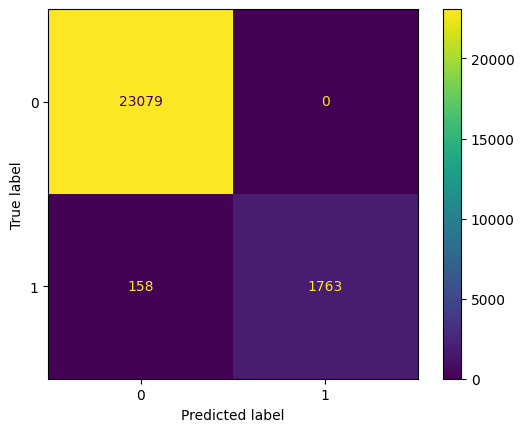

In [79]:
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test)

In [80]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
class_names = ['person', 'government']

dot_data = export_graphviz(dt, out_file=None, feature_names=list(X_train.columns), class_names=class_names,
                           filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render("iris_decision_tree", format='png', cleanup=True)


'iris_decision_tree.png'

As an extra level of comparison we looked at small sample of datapoints (200) which we hand labeled by looking at name and extra_info columns. We then investigated matches b/t the decision tree model and our hand labels.

In [81]:
model_labels = dt.predict(X)

## Foundational NER Model ZeroShot Using gliner_spacy


1. Import a foundational spacy NER model that can recognize 18 entities.  Model Documentation [here](https://spacy.io/models/en#en_core_web_sm)
2. Add the gliner_spacy to nlp pipe and configure for both labels
3. Add the zero shot labels to a sample of 2k observations (due to comptational resources needed a smaller data set)

We decided to take a smaller sample/subset of our dataframe to compare foundational model and tuned NER model below. This is due to time and computational contraints. We can compare this smaller smaple with the results of the rule based approach above. We expected this pre-trained model to struggle with identifying government entities as this is not a named entity within the spacy model.



In [7]:
samp_df_spacy_v2 = samp_df.sample(2000, random_state=101)

In [114]:
#load spacy small model--built on wikipedia and other media text
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("gliner_spacy", config={"labels": ['person', 'government' ]})

In [84]:
# Create an empty list to store the labels
labels_list = []

# Iterate over the 'text_column' using spaCy
for text in samp_df_spacy_v2['name']:
    doc = nlp(text)
    # Process the text as needed
    # For example, store entities in each document
    labels = [ent.label_ for ent in doc.ents]
    #print(text,labels)
    labels_list.append(labels)

# Add the labels as a new column to the DataFrame
samp_df_spacy_v2['zero_shot_labels'] = labels_list

In [85]:
samp_df_spacy_v2.head()

,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,cityof_regex,...,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels
67781,william m. polatty,NaN,personal_injury,['paed;;2:09-cv-74147'],"[william, m., polatty]",[],3,0,0,0,...,0,0,1,1.000,0.000,1,0,person,0,[person]
52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"[farah, bellah, hamouda]",[],3,0,0,0,...,0,0,1,1.000,0.000,1,0,person,0,[]
60644,richard w. story,NaN,civil_rights,['dcd;;1:17-cv-02364'],"[richard, w., story]",[],3,0,0,0,...,0,0,1,1.000,0.000,1,0,person,0,[person]
43620,welcome rose,NaN,habeas_corpus,"['wied;;2:17-cv-00766', 'wied;;2:16-cv-01503',...","[welcome, rose]",[],2,0,0,0,...,0,1,0,1.000,0.000,1,0,person,0,[person]
9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"[fnu, primo]","[correctional, officer]",2,0,0,0,...,0,1,0,1.000,1.000,1,0,government,1,[]


In [86]:
samp_df_spacy_v2['zero_shot_labels'].value_counts(normalize=True)

zero_shot_labels
[person]                                               0.571
[]                                                     0.311
[government]                                           0.056
[person, person]                                       0.045
[person, person, person]                               0.004
[government, government]                               0.004
[person, government]                                   0.004
[government, person]                                   0.003
[person, person, person, person]                       0.001
[person, person, person, person, person, government]   0.001
[government, government, government]                   0.001
[government, government, person]                       0.001
[person, person, government]                           0.001
Name: proportion, dtype: float64

As expected the zero shot model was able to pick up on person fairly well but really struggled with entifying government entities. It also resulted in identifying multiple entities for some rows, we will bin all 'person' or 'government' together and create a third label for 'both entities'. We hope to use fine tuning below to prevent this in our tuned NER model. We have also grouped blank or no-entity into person we did above.

In [87]:
#Store df output above as CSV
samp_df_spacy_v2.to_csv("/content/samp_df_2k_labels.csv")

In [8]:
# Load in data from above
samp_df_spacy_v2 = pd.read_csv("/content/samp_df_2k_labels.csv")
samp_df_spacy_v2.head()

,Unnamed: 0,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,...,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels
0,67781,william m. polatty,NaN,personal_injury,['paed;;2:09-cv-74147'],"['william', 'm.', 'polatty']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,['person']
1,52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"['farah', 'bellah', 'hamouda']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,[]
2,60644,richard w. story,NaN,civil_rights,['dcd;;1:17-cv-02364'],"['richard', 'w.', 'story']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,['person']
3,43620,welcome rose,NaN,habeas_corpus,"['wied;;2:17-cv-00766', 'wied;;2:16-cv-01503',...","['welcome', 'rose']",[],2,0,0,...,0,1,0,1.0,0.0,1,0,person,0,['person']
4,9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"['fnu', 'primo']","['correctional', 'officer']",2,0,0,...,0,1,0,1.0,1.0,1,0,government,1,[]


In [10]:
samp_df_spacy_v2['target_v1'].value_counts(normalize=True)

target_v1
person              0.7835
no_condition_met    0.1415
government          0.0750
Name: proportion, dtype: float64

In [89]:
# Defining a function to bin and put labels from above model into a standard format for comparison
def switcher(x):
  if x == "['person']":
    return 'person'
  elif x == "['person', 'person', 'person']":
    return 'person'
  elif x == "['person', 'person']":
    return 'person'
  elif x == "['person', 'person', 'person', 'person']":
    return 'person'
  elif x == "['government']":
    return 'government'
  elif x == "['government', 'government', 'government']":
    return 'government'
  elif x == "['government', 'government']":
    return 'government'
  elif x == "[]":
    return 'no_condition_met'
  else:
    return 'both labels'

In [90]:
samp_df_spacy_v2['zero_shot_labels_v2'] = samp_df_spacy_v2['zero_shot_labels'].apply(switcher)
samp_df_spacy_v2.head()

,Unnamed: 0,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,...,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels,zero_shot_labels_v2
0,67781,william m. polatty,NaN,personal_injury,['paed;;2:09-cv-74147'],"['william', 'm.', 'polatty']",[],3,0,0,...,0,1,1.000,0.000,1,0,person,0,['person'],person
1,52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"['farah', 'bellah', 'hamouda']",[],3,0,0,...,0,1,1.000,0.000,1,0,person,0,[],no_condition_met
2,60644,richard w. story,NaN,civil_rights,['dcd;;1:17-cv-02364'],"['richard', 'w.', 'story']",[],3,0,0,...,0,1,1.000,0.000,1,0,person,0,['person'],person
3,43620,welcome rose,NaN,habeas_corpus,"['wied;;2:17-cv-00766', 'wied;;2:16-cv-01503',...","['welcome', 'rose']",[],2,0,0,...,1,0,1.000,0.000,1,0,person,0,['person'],person
4,9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"['fnu', 'primo']","['correctional', 'officer']",2,0,0,...,1,0,1.000,1.000,1,0,government,1,[],no_condition_met


In [91]:
samp_df_spacy_v2['zero_shot_labels_v2'].value_counts(normalize=True)

zero_shot_labels_v2
person             0.621
no_condition_met   0.311
government         0.060
both labels        0.008
Name: proportion, dtype: float64

In [92]:
#Match our rule-based labels against spacy model
def match_check(row):
    if row['target_v1'] == row['zero_shot_labels_v2']:
        return 1
    else:
        return 0

In [93]:
samp_df_spacy_v2['match'] = samp_df_spacy_v2.apply(match_check, axis=1)

In [94]:
#How many were matched -- roughly 59%
samp_df_spacy_v2['match'].value_counts(normalize=True)


match
1   0.586
0   0.414
Name: proportion, dtype: float64

The zero shot labels match ~59% of our rule based target labels created earlier. It mostly matched on the person entity and only matched with 11 of the rows marked as government, somewhat expected for the zero shot model as it does, pre-trained, contain a person entity but not a set government entity which we forced it to try and recognize.

In [96]:
samp_df_spacy_v2[samp_df_spacy_v2['match'] == 1]['target_v1'].value_counts()

target_v1
person              1043
no_condition_met     117
government            11
Name: count, dtype: int64

In [97]:
#Look at those spacy wasn't able to match
samp_df_spacy_v2.loc[samp_df_spacy_v2['zero_shot_labels']== "[]"]

,Unnamed: 0,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,...,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels,zero_shot_labels_v2,match
1,52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"['farah', 'bellah', 'hamouda']",[],3,0,0,...,1,1.000,0.000,1,0,person,0,[],no_condition_met,0
4,9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"['fnu', 'primo']","['correctional', 'officer']",2,0,0,...,0,1.000,1.000,1,0,government,1,[],no_condition_met,0
5,57023,16572888096,NaN,property_rights,['ilnd;;1:21-cv-00010'],['16572888096'],[],1,0,0,...,0,1.000,0.000,1,0,no_condition_met,0,[],no_condition_met,1
9,28844,mia lytell,NaN,other_statutes,['nyed;;1:17-cv-06404'],"['mia', 'lytell']",[],2,0,0,...,0,1.000,0.000,1,0,person,0,[],no_condition_met,0
10,79927,village of northfield,the,civil_rights,['ilnd;;1:18-cv-07028'],"['village', 'of', 'northfield']",['the'],3,0,0,...,1,1.000,0.000,1,0,person,0,[],no_condition_met,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,72133,"intra-urban investments, llc",NaN,civil_rights,['oked;;6:17-cv-00295'],"['intra-urban', 'investments', ',', 'llc']",[],4,0,0,...,0,1.000,0.000,0,0,person,0,[],no_condition_met,0
1988,36522,cija,a utah limited liability company,civil_rights,['utd;;2:16-cv-00473'],['cija'],"['a', 'utah', 'limited', 'liability', 'company']",1,0,0,...,0,1.000,0.000,1,0,no_condition_met,0,[],no_condition_met,1
1993,29862,red barn trees and landscape,a utah corporation,labor,['utd;;2:17-cv-00107'],"['red', 'barn', 'trees', 'and', 'landscape']","['a', 'utah', 'corporation']",5,0,0,...,0,1.000,0.000,1,0,no_condition_met,0,[],no_condition_met,1
1997,56492,s.s.g. fashions ltd.,NaN,property_rights,['nysd;;1:17-cv-01856'],"['s.s.g', '.', 'fashions', 'ltd', '.']",[],5,0,0,...,0,1.000,0.000,1,0,no_condition_met,0,[],no_condition_met,1


Looking at the no_condition_met columns for our zero shot model, it seems to struggle with particular names and specifc company information that is it not reconigizing as an entity. We will attempt to rememdy via a custom NER model by fine tuning it with fake names and titles created below.

## Tuned NER Spacy model

Creating a custom model and fine tuning with 'training data' to see if it can help performance and pick up on more entities.


1. Use Faker to generate fake English, Spanish, and English Indian names
2. Create a text file of 'formal titles' (found in data folder) and of person suffixes (l.l.c, .inc, etc.) - created using GenAI
4. Append these files together to generate names with formal titles labeled 'government' and names with person suffixes labeled 'person'
3. Add this custom data to the LLM pipe





In [11]:
# Uncomment to install
#!pip install faker
#!pip install Faker
from faker import Faker
import random

In [12]:
#Need fake names that we can add formal government titles to in order to

fake = Faker()
# Generate 100 English names
english_names = [fake.name() for _ in range(100)]

fake_span = Faker("es_ES")
# Generate 100 Spanish names
spanish_names = [fake_span.name() for _ in range(100)]

fake_engindian = Faker("en_IN")
# Generate 100 English Indian names
english_indian_names = [fake_engindian.name() for _ in range(100)]

In [13]:
#Put all the names in one list
all_names_train = english_names + spanish_names + english_indian_names

In [14]:
all_names_train[50:100]

['Julie Boyer',
 'Deborah Chandler',
 'Brandon Wood',
 'Victoria Fisher',
 'Colton Gibson',
 'Alexander Chavez',
 'Kevin Burton',
 'Kenneth Copeland',
 'Tyler Snyder',
 'Stephanie Cooper',
 'Samantha Zhang',
 'Beth Peterson',
 'Christopher Wagner',
 'Caitlin Romero',
 'Anthony Torres',
 'Elizabeth Mcdonald',
 'Sarah Flynn',
 'Richard Lindsey',
 'Kyle Gardner',
 'Jessica Moore',
 'Christopher Deleon',
 'Patrick Adams',
 'Jeremy Perez',
 'Timothy Moore',
 'Greg Snyder',
 'Charlene Lopez',
 'Lindsey Williams',
 'Kelly Wilkerson',
 'Rebecca Perry',
 'Christina Cardenas',
 'Kristin Chandler',
 'Seth Wilson',
 'Jennifer Gordon',
 'Sharon French',
 'Courtney Sanchez',
 'Rhonda Williams',
 'Tammy Stout',
 'Barry May',
 'Kelsey Price',
 'Rachel Snyder',
 'Michael Cox',
 'Gregory Blevins',
 'Nicole Boyd',
 'Chelsea Keller',
 'Eric Gentry',
 'Julia Davies',
 'Andrew Morgan',
 'Elizabeth Green',
 'Amber Lopez',
 'Jeffrey Boyd']

In [15]:
#Need 'government' titles to add to the names - these should be similar to our formal titles checked with regex rules approve
formal_titles = pd.read_csv("/content/formal_names_scales.txt", sep="\t", header=None, names=['title'])
formal_titles.head()

,title
0,district attorney
1,d.a.
2,officer
3,lieutenant
4,correctional officer


In [16]:
# Loop through random names and titles to create synthetic training data for government entity
num_entities = 1000
entities = []

for _ in range(num_entities):
    # Select a random name and title
    random_name = random.choice(all_names_train)
    random_title = random.choice(formal_titles['title'])  # Assuming titles are in the first column of the DataFrame

    # Concatenate the name and title together
    entity_label = 'government'
    entity_text = f'{random_title} {random_name}'

    # Add the generated entity to the list of dictionaries
    entity_dict = {"pattern": entity_text, "label": entity_label}
    entities.append(entity_dict)

In [17]:
print(entities[:20])

[{'pattern': 'inspector Siya Din', 'label': 'government'}, {'pattern': 'president Adelina Torres Durán', 'label': 'government'}, {'pattern': 'police officer  Celestina Mendez Iglesia', 'label': 'government'}, {'pattern': 'detective Christina Cardenas', 'label': 'government'}, {'pattern': 'warden Candelaria Porta-Barriga', 'label': 'government'}, {'pattern': 'col Carina Gaya Estévez', 'label': 'government'}, {'pattern': 'investigator Christopher Wagner', 'label': 'government'}, {'pattern': 'president Rebecca Perry', 'label': 'government'}, {'pattern': 'undercover officer Alfonso Acosta Olivera', 'label': 'government'}, {'pattern': 'attorney general Navya Gokhale', 'label': 'government'}, {'pattern': "sheriff's deputy Martina Valentín Cañellas", 'label': 'government'}, {'pattern': 'auditor Yuvaan Dhillon', 'label': 'government'}, {'pattern': 'treas. Mahika Grewal', 'label': 'government'}, {'pattern': 'admiral Colton Gibson', 'label': 'government'}, {'pattern': 'p.o. Vivaan Gulati', 'labe

In [18]:
# Need person data
persons = pd.read_csv("/content/person_Scales.txt", sep="\t", header=None, names=['abbrev'])
persons.head()

,abbrev
0,llc
1,limited liability company
2,l.l.c.
3,inc
4,.inc


In [19]:
# Person Loop for another 1000 synthetic entities for person labels
num_entities = 1000

for _ in range(num_entities):
    # Select a random name and title
    random_name = random.choice(all_names_train)
    random_title = random.choice(persons['abbrev'])  # Assuming titles are in the first column of the DataFrame

    # Concatenate the name and title together
    entity_label = 'person'
    entity_text = f'{random_name} {random_title}'

    # Add the generated entity to the list of dictionaries
    entity_dict = {"pattern": entity_text, "label": entity_label}
    entities.append(entity_dict)

In [20]:
print(entities[1000:1020])

[{'pattern': 'Victoria Fisher incorporated', 'label': 'person'}, {'pattern': 'Caitlin Romero ltd ', 'label': 'person'}, {'pattern': 'Jacqueline Garcia llc ', 'label': 'person'}, {'pattern': 'Rogelio Boada Santiago corporation', 'label': 'person'}, {'pattern': 'Aarav Bava .inc', 'label': 'person'}, {'pattern': 'Elizabeth Mcdonald company', 'label': 'person'}, {'pattern': 'Timothy Moore public limited company', 'label': 'person'}, {'pattern': 'Kashvi Sibal lp ', 'label': 'person'}, {'pattern': 'Advik Tara limited liability partnership', 'label': 'person'}, {'pattern': 'Miguel Gordillo Carranza .inc', 'label': 'person'}, {'pattern': 'Casandra Abad Portillo limited liability company', 'label': 'person'}, {'pattern': 'Prisha Biswas llc ', 'label': 'person'}, {'pattern': 'Nitara Chander ltd ', 'label': 'person'}, {'pattern': 'Kristin Chandler limited liability partnership', 'label': 'person'}, {'pattern': 'Felisa del Chamorro limited liability company', 'label': 'person'}, {'pattern': 'Paco 

In [21]:
len(entities)

2000

In [22]:
samp_df_spacy_v2.head()

,Unnamed: 0,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,dept_of_regex,...,dept_regex,two_tokens,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels
0,67781,william m. polatty,NaN,personal_injury,['paed;;2:09-cv-74147'],"['william', 'm.', 'polatty']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,['person']
1,52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"['farah', 'bellah', 'hamouda']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,[]
2,60644,richard w. story,NaN,civil_rights,['dcd;;1:17-cv-02364'],"['richard', 'w.', 'story']",[],3,0,0,...,0,0,1,1.0,0.0,1,0,person,0,['person']
3,43620,welcome rose,NaN,habeas_corpus,"['wied;;2:17-cv-00766', 'wied;;2:16-cv-01503',...","['welcome', 'rose']",[],2,0,0,...,0,1,0,1.0,0.0,1,0,person,0,['person']
4,9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"['fnu', 'primo']","['correctional', 'officer']",2,0,0,...,0,1,0,1.0,1.0,1,0,government,1,[]


We utlized the **en_core_web_sm** as a source for our NER from spacy. And then iterated through the synthetic entities above to attempt our fine tuning of the model. The primary goal here is to pick up on more government entities and reduce the number of no_condition_met results. We started at a low number of iterations (10) which resulted in very heavy hand towards government (too heavy). Ended with running 100 iterations.

In [25]:
# Code to fine tune spacy NER
from spacy.training import Example

# Load a pre-trained SpaCy model
nlp = spacy.load("en_core_web_sm")
#nlp = spacy.blank("en")
#nlp.add_pipe("gliner_spacy", config={"labels": ['person', 'government' ]})
#Add named entity labels
#ner = nlp.add_pipe("ner", name='custom_ner')
#ner.add_label('person')
#ner.add_label('government')
disabled_pipes = []
for pipe_name in nlp.pipe_names:
  if pipe_name != 'ner':
    nlp.disable_pipes(pipe_name)
    disabled_pipes.append(pipe_name)

# Convert training data to SpaCy's training format
train_data = []
for entity in entities:
    if entity["label"] in ["person", "government"]:  # Filter out other labels
        train_data.append((entity["pattern"], {"entities": [(0, len(entity["pattern"]), entity["label"])]}))

# Train the NER model
optimizer = nlp.create_optimizer()
for _ in range(25):  # Adjust the number of training iterations as needed -
    random.shuffle(train_data)
    for text, annotations in train_data:
        example = Example.from_dict(nlp.make_doc(text), annotations)
        nlp.update([example], sgd=optimizer, drop=0.25)

for pipe_name in disabled_pipes:
  nlp.enable_pipe(pipe_name)


# Once update and fine tuning utilize model to find entities
labels_list = []

for text in samp_df_spacy_v2['name']:
    doc = nlp(text)
    # Process the text as needed
    # For example, store entities in each document
    labels = [ent.label_ for ent in doc.ents]
    #print(text,labels)
    labels_list.append(labels)

# Add the labels as a new column to the DataFrame
samp_df_spacy_v2['tuned_ner_labels'] = labels_list

In [28]:
# Once model has been tuned we want to save to off via spacy internal serialization method
nlp.to_disk("tuned_ner_pipe")

In [29]:
samp_df_spacy_v2['tuned_ner_labels'].value_counts(normalize=True)

tuned_ner_labels
[government]                            0.9490
[]                                      0.0405
[government, government]                0.0080
[person]                                0.0020
[government, government, government]    0.0005
Name: proportion, dtype: float64

We attempted a series of iterations and setup involving the creation of a custom NER model, currently with limited success but am confident that this process could concievably work given the right custom training entities and text. Further improvement of the entities/examples given during the update should have a positive affect on the model performance. As it stands, the tuned model is leaning heavily towards assigning almost all entities as government. This is a starting base to improve and continued iteration is needed to refine desired outcome.

In [30]:
# Save the resulting df with tuned model labels to csv
samp_df_spacy_v2.to_csv("samp_df_tuned_labels.csv")

# Load back in
samp_df_spacy_v3 = pd.read_csv("samp_df_tuned_labels.csv")

In [31]:
def switcher_tuned(x):
  if x == "['person']":
    return 'person'
  elif x == "[]":
    return 'no_condition_met'
  else:
    return 'government'

In [36]:
samp_df_spacy_v3['tuned_ner_labels_v2'] = samp_df_spacy_v3['tuned_ner_labels'].apply(switcher_tuned)
samp_df_spacy_v3.head()

,Unnamed: 0.1,Unnamed: 0,name,extra_info,nature_suit_subtype,ucids,name_tokenized,extra_info_tokenized,token_count,let_period_let_regex,...,three_tokens,extra_info_notindiv_regex,extra_info_formal_regex,word_llc_regex,inc_regex,target_v1,target_v2,zero_shot_labels,tuned_ner_labels,tuned_ner_labels_v2
0,0,67781,william m. polatty,NaN,personal_injury,['paed;;2:09-cv-74147'],"['william', 'm.', 'polatty']",[],3,0,...,1,1.0,0.0,1,0,person,0,['person'],['government'],government
1,1,52878,farah bellah hamouda,NaN,personal_injury,['ilnd;;1:10-cv-00467'],"['farah', 'bellah', 'hamouda']",[],3,0,...,1,1.0,0.0,1,0,person,0,[],['government'],government
2,2,60644,richard w. story,NaN,civil_rights,['dcd;;1:17-cv-02364'],"['richard', 'w.', 'story']",[],3,0,...,1,1.0,0.0,1,0,person,0,['person'],['government'],government
3,3,43620,welcome rose,NaN,habeas_corpus,"['wied;;2:17-cv-00766', 'wied;;2:16-cv-01503',...","['welcome', 'rose']",[],2,0,...,0,1.0,0.0,1,0,person,0,['person'],['government'],government
4,4,9912,fnu primo,correctional officer,habeas_corpus,['txed;;1:20-cv-00485'],"['fnu', 'primo']","['correctional', 'officer']",2,0,...,0,1.0,1.0,1,0,government,1,[],['government'],government


In [37]:
samp_df_spacy_v3['tuned_ner_labels_v2'].value_counts(normalize=True)

tuned_ner_labels_v2
government          0.9575
no_condition_met    0.0405
person              0.0020
Name: proportion, dtype: float64

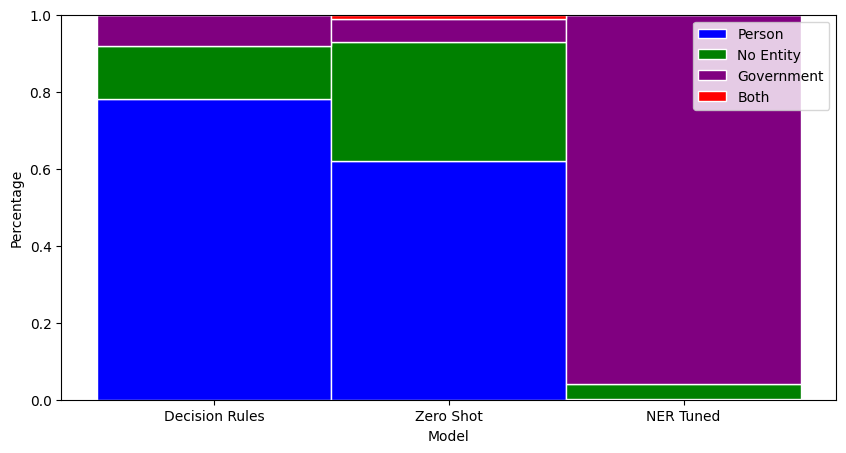

In [59]:
# Comparison bar chart for all three methods, percentage of category
import matplotlib.pyplot as plt

# Values for bars, pulled from normalized value_counts() in order of person - no entity - government - both
bars1 = [.78, .62, .002]
bars2 = [.14, .31, .04]
bars3 = [.08, .06, .958]
bars4 = [.0, .01, .0]

# bar heights
bar1_2 = np.add(bars1, bars2)

# A-axis postions
r = [0, 1, 2]
names = ['Decision Rules', 'Zero Shot', 'NER Tuned']
barwidth = 1

fig, ax = plt.subplots(figsize=(10,5))
# First bars
plt.bar(r, bars1, color='blue', edgecolor='white', width=barwidth)
# Second bars
plt.bar(r, bars2, bottom=bars1, color='green', edgecolor='white', width=barwidth)
# Third bars
plt.bar(r, bars3, bottom=bar1_2, color='purple', edgecolor='white', width=barwidth)
# Fourth bars
plt.bar(r, bars4, bottom=bar1_2_3, color='red', edgecolor='white', width=barwidth)

plt.ylabel('Percentage')

# X axis labels
plt.xticks(r, names)
plt.xlabel('Model')
ax.legend(labels=['Person', 'No Entity', 'Government', 'Both']);

## Learnings and Recommendations


*  As it stands the rule based approach is performing the best, followed by the gliner zero-shot. The big downside for both models currently is the number of unlabeled (no_condition_met) values that neither could identify as 'person' or 'government'.
*  Creating finite rules to determine a target then running a Machine Learning model against that target performs pretty well
*  The limitations are the difficulty in being able to define almost all the rules needed to create a robust target and having computational resources to train a foundational model with custom training data
*  Even though the zero-shot LLM model was ~59% accurate in relation to rule based target, it can still be used to identify names that were matched to both labels for further investigation and to help create more rules
*  Custom training data could potentially be used to train the model but computational (cloud) resources would be needed since it has difficulty performing on just a local machine, and specific text and entities (essentially based on rules) would need to hand crafted.





## Future Steps


*  Determine more rules that can separate 'government' from 'person' entities by combing through sample text and picking out key words and patterns to identify via regex
*  Utilize cloud environment to gain further computing power, allowing larger samples and further/faster iteration of fine-tuning
*  Hand craft more training examples to gain more finite fine-tuning and entity/pattern recognition


